This notebook explores the data to gain understanding of the available + engineered features and how they are related with the goal of the project.

This will allow us to clarify how we want to pre-process the data before modelling.

In [3]:
import os
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy

In [2]:
# ! python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# 1 Load Data

In [5]:
file_path = Path(os.path.abspath('')).parent / "data" / "reviews.csv"
df = pd.read_csv(file_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


## 1.1 Description

The article being reviewed is identified by the **Clothing ID**. Each article belongs to one type of **Class Name**, which itself is part of one **Department Name**.

The column **Division Name** desribes the section of the store. Most articles are present in both divisions.

The columns **Title**, **Review Text**, **Positive Feedback Count** and **Recommended IND** compose the review.

The column **Age** relates the person doing the review.

**Recommended IND** is either 1 or 0. The average for a specific article describes the **Recommendation Probability**, which we want to predict for future articles.

## 1.2 Clean-up

Clothing ID maps to only one Class Name. As shown below, the exception is **Clothing ID = 1119**, which is for **Jackets** in **General Petite** and for **Outwear** in **General**.

Substitute one of the Clothing IDs.

In [6]:
# running this code a second time returns no output
clothing_class_counts = df.groupby('Clothing ID')['Class Name'].nunique()
multiple_class_ids = clothing_class_counts[clothing_class_counts > 1]

for id in multiple_class_ids.index:
    print(df[df['Clothing ID'] == id]['Class Name'].tolist())
    print(df[df['Clothing ID'] == id]['Division Name'].tolist())
    
    next_id = max(df['Clothing ID']) + 1
    df.loc[(df['Clothing ID'] == id) & (df['Division Name'] == "General"), 'Clothing ID'] = next_id

['Jackets', 'Jackets', 'Outerwear', 'Outerwear', 'Outerwear', 'Outerwear']
['General Petite', 'General Petite', 'General', 'General', 'General', 'General']


In [7]:
# Duplicate recommended column as text for the plots
df["Review"] = df["Recommended IND"].map({1: 'Positive', 0: 'Negative'})

# 2 Clothing ID Statistics

The number of reviews for an article is log-distributed.

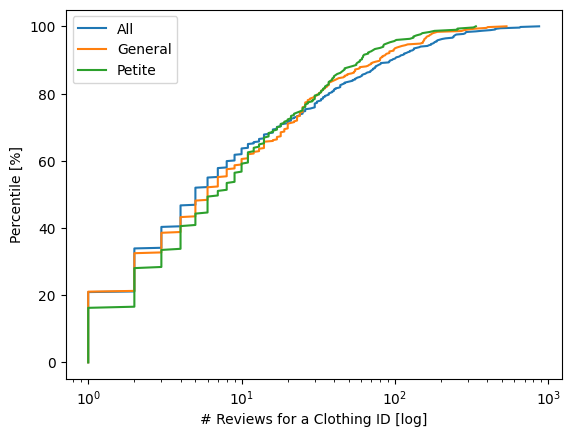

In [ ]:

plt.figure()

clothing_counts = df['Clothing ID'].value_counts()
plt.semilogx(sorted(clothing_counts), np.linspace(0, 100, len(clothing_counts)), label="All")

clothing_counts_general = df[df['Division Name'] == 'General']['Clothing ID'].value_counts()
plt.semilogx(sorted(clothing_counts_general), np.linspace(0, 100, len(clothing_counts_general)), label="General")

clothing_counts_petite = df[df['Division Name'] == 'General Petite']['Clothing ID'].value_counts()
plt.semilogx(sorted(clothing_counts_petite), np.linspace(0, 100, len(clothing_counts_petite)), label="Petite")

plt.xlabel("# Reviews for a Clothing ID [log]")
plt.ylabel("Percentile [%]")
plt.legend()
plt.show()

With increasing number of reviews each article approximates a recommentation probability of ~0.8 for all classes.

c:\workspace\sources_git\dsnd-pipelines-project\.venv\Lib\site-packages\seaborn\axisgrid.py:854: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)


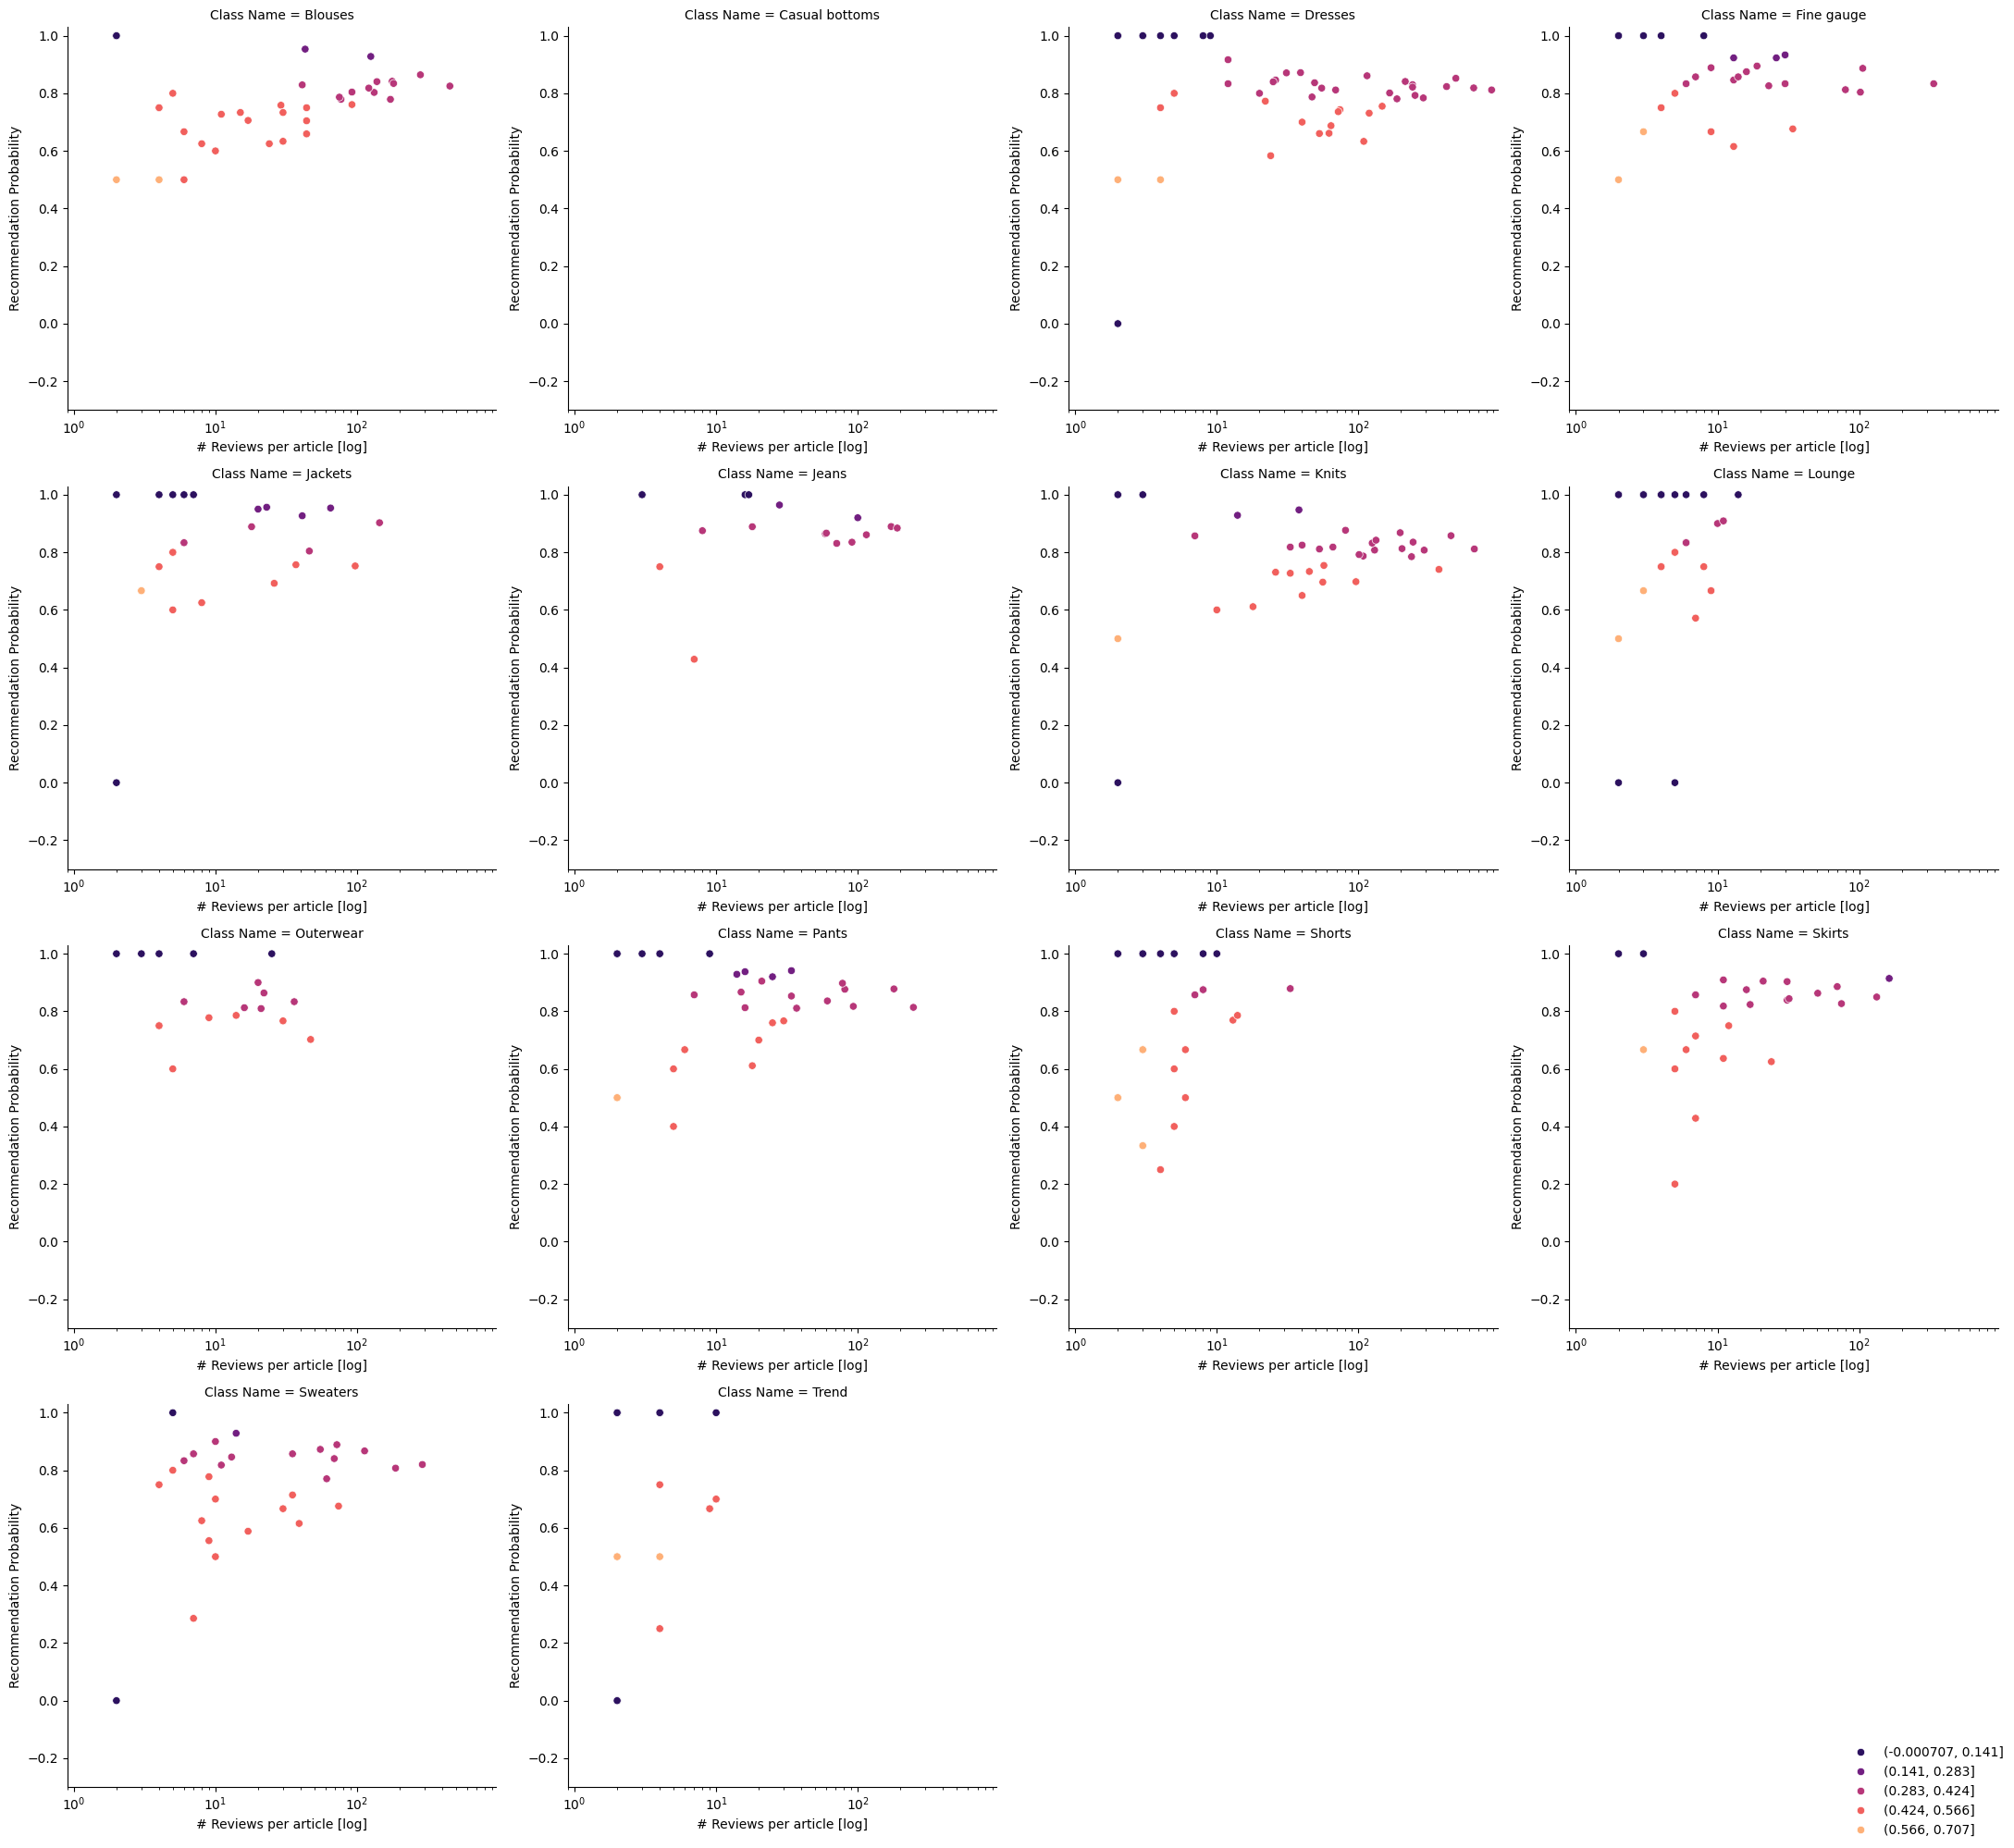

In [72]:
# Aggregate Clothing ID counts and recommendation rates
clothing_stats = df.groupby(['Class Name', 'Clothing ID']).agg(
    count=('Clothing ID', 'size'),
    recommendation_rate=('Recommended IND', 'mean'),
    recommendation_std=('Recommended IND', 'std'),
).reset_index()

clothing_stats['recommendation_variability'] = pd.cut(clothing_stats['recommendation_std'], bins=5)

g = sns.FacetGrid(clothing_stats, col="Class Name", col_wrap=4, height=5, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="count", y="recommendation_rate", hue="recommendation_variability", palette="magma")
g.add_legend(loc='lower right')

for ax in g.axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(0.9, 1.1 * clothing_stats['count'].max())
    ax.set_ylim(-0.3, 1.03)
    ax.set_xlabel("# Reviews per article [log]")
    ax.set_ylabel("Recommendation Probability")

plt.tight_layout()
plt.show()

The variance and the mean of the recommendation are related. This shows that the review follows a Bernoulli process with p = recommendation probability.

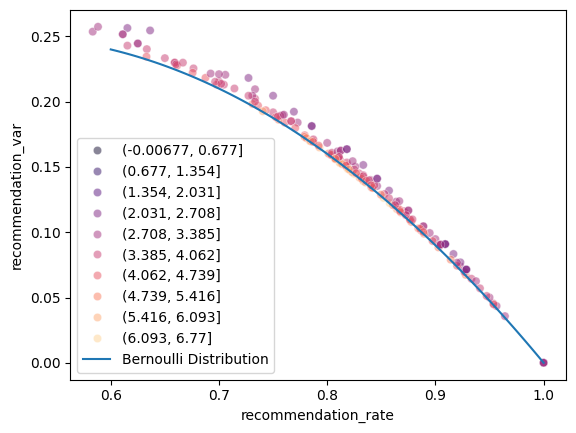

In [73]:
clothing_stats = df.groupby(['Class Name', 'Clothing ID']).agg(
    count=('Clothing ID', 'size'),
    recommendation_rate=('Recommended IND', 'mean'),
    recommendation_var=('Recommended IND', 'var'),
).reset_index()

clothing_stats['log_count_bins'] = pd.cut(np.log(clothing_stats['count']), bins=10)

f = clothing_stats[clothing_stats['count'] > 10]
g = sns.scatterplot(data=f, x="recommendation_rate", y="recommendation_var", hue='log_count_bins', palette="magma", alpha=0.5)
p = np.linspace(0.6, 1, 100)
plt.plot(p, p * (1 - p), label="Bernoulli Distribution")
plt.legend()
plt.show()

# 3 Division Statistics

Does the division have a direct influence on the positive review probability?

Conclusions:
* There is a different availability of articles between divisions.
* There is no division that outperforms the other in overall positive reviews.
* When available in both division, some articles differ in the recommendation probability between divisions.

## 3.1 Total number of reviews and distribution of individual articles per Division

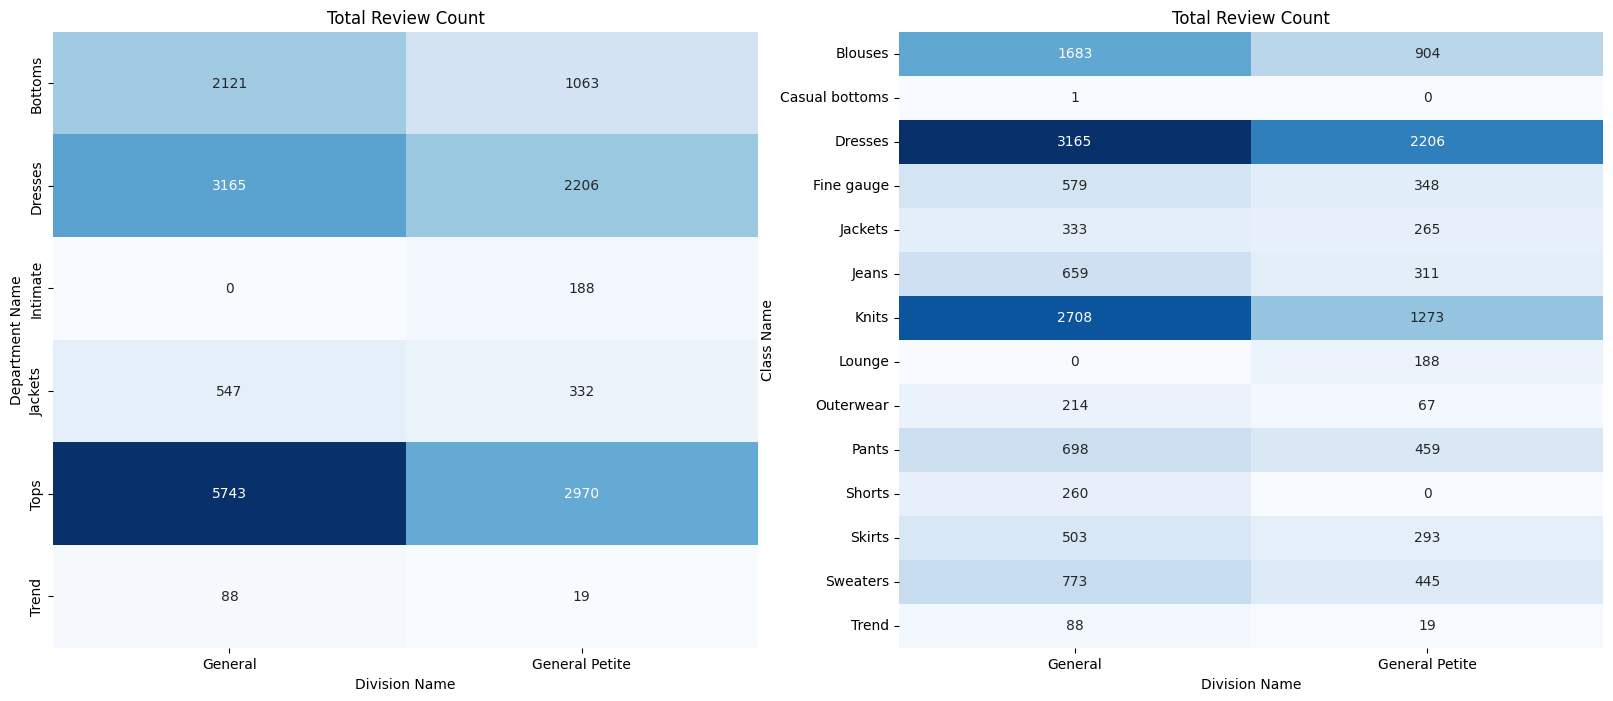

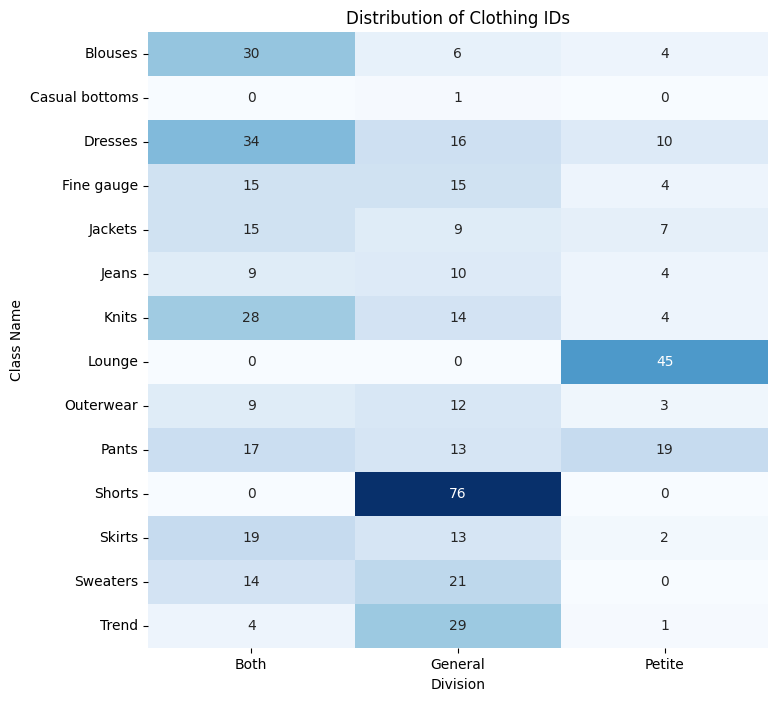

In [5]:
# Item Count
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

pivot_department = df.pivot_table(index='Department Name', columns='Division Name', aggfunc='size', fill_value=0)
sns.heatmap(pivot_department, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title("Total Review Count")

pivot_class = df.pivot_table(index='Class Name', columns='Division Name', aggfunc='size', fill_value=0)
sns.heatmap(pivot_class, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title("Total Review Count")

plt.show()


# Distribution of clothing IDs
plt.figure(figsize=(8, 8))

clothing_division = df.groupby(['Clothing ID', 'Division Name']).size().unstack(fill_value=0)

clothing_division['Division'] = 'Both'
clothing_division.loc[(clothing_division['General'] > 0) & (clothing_division['General Petite'] == 0), 'Division'] = 'General'
clothing_division.loc[(clothing_division['General Petite'] > 0) & (clothing_division['General'] == 0), 'Division'] = 'Petite'

clothing_class = df[['Clothing ID', 'Class Name']].drop_duplicates()
merged = pd.merge(clothing_class, clothing_division[['Division']], on='Clothing ID')
pivot_table = merged.pivot_table(index='Class Name', columns='Division', aggfunc='size', fill_value=0)

sns.heatmap(pivot_table, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Distribution of Clothing IDs')
plt.show()

Observations:
* General Division sells more articles than Petite in each department and class.
* **Intimate: Lounge** is only available in Petite.
* **Shorts** are only available in the General Division.
* **Casual Bottoms** has only one item in the General Division. Consider removing it.
* Most articles are available in both Division, but there are some that are exclusively in one of them.

## 3.2 Recommendation Probability per Division

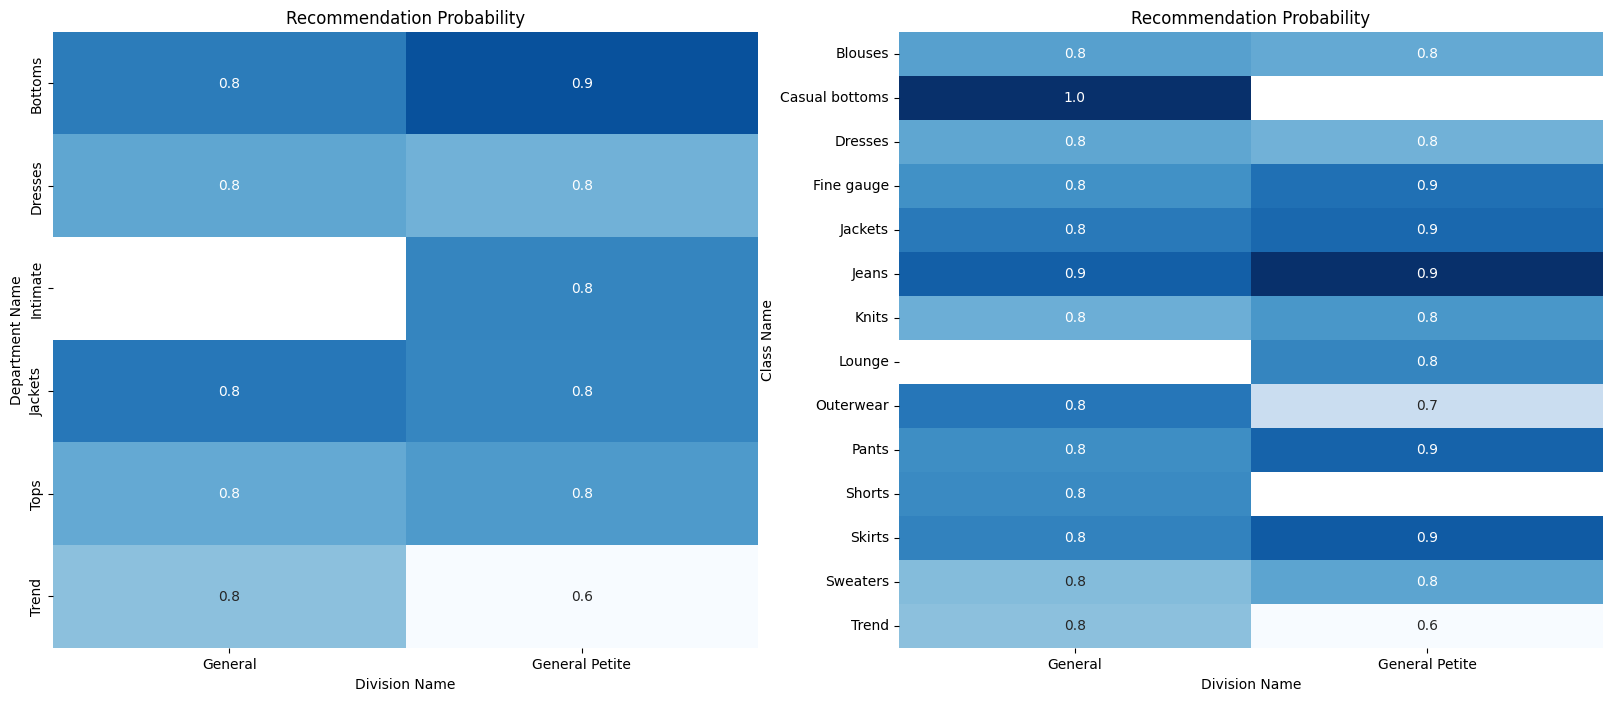

In [7]:
# % Recommended
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

pivot_department = df.groupby(['Department Name', 'Division Name'])['Recommended IND'].mean().unstack()
sns.heatmap(pivot_department, annot=True, fmt=".1f", cmap='Blues', cbar=False, ax=axes[0], vmin=0.70, vmax=0.90)
axes[0].set_title("Recommendation Probability")

pivot_class = df.groupby(['Class Name', 'Division Name'])['Recommended IND'].mean().unstack()
sns.heatmap(pivot_class, annot=True, fmt=".1f", cmap='Blues', cbar=False, ax=axes[1], vmin=0.70, vmax=0.90)
axes[1].set_title("Recommendation Probability")

plt.show()

Run again, but calculate the recommendation probability of the Clothing IDs first and then average.

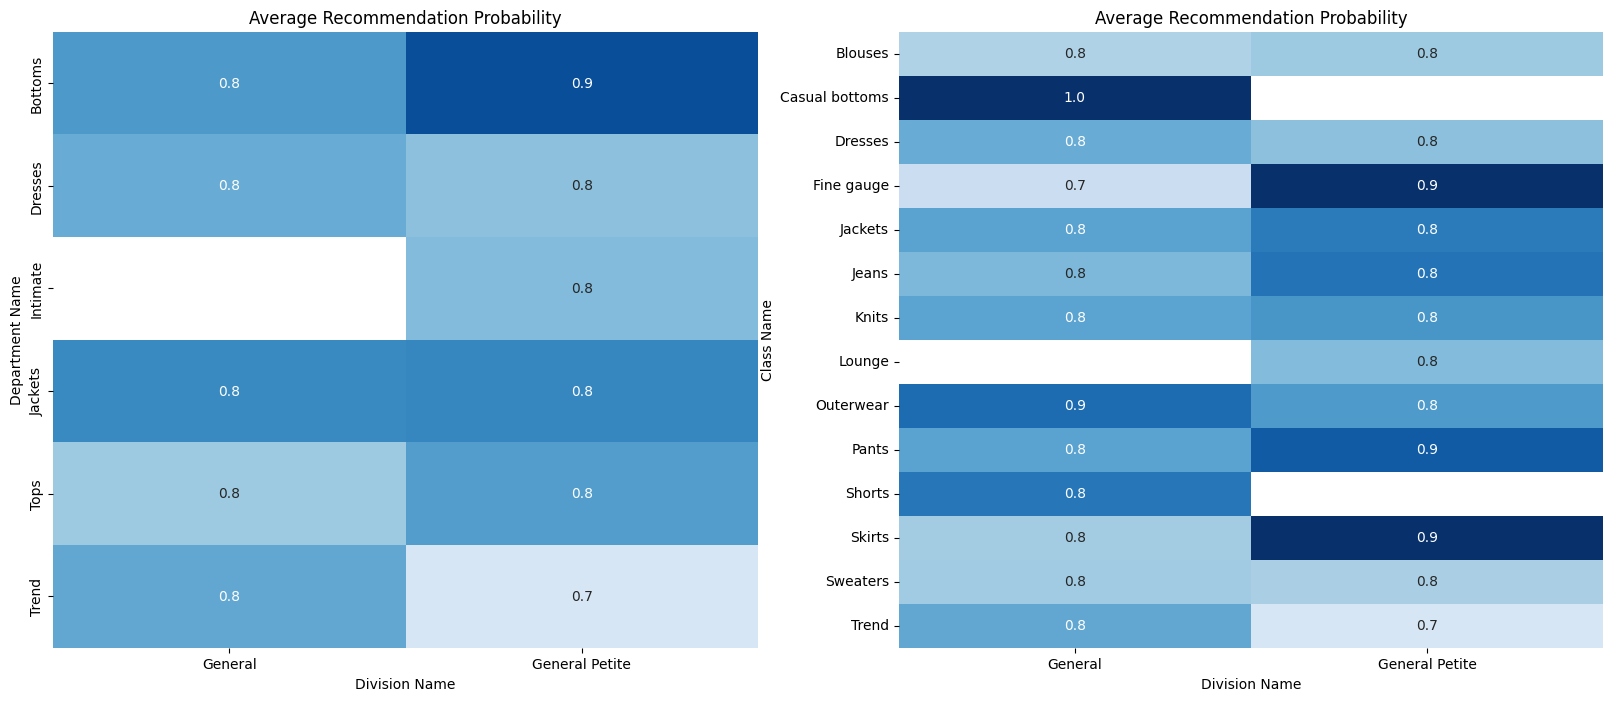

In [8]:
# % Average Article recommendation
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

clothing_avg = df.groupby(['Clothing ID', 'Department Name', 'Division Name'])['Recommended IND'].mean().reset_index()
pivot_department = clothing_avg.groupby(['Department Name', 'Division Name'])['Recommended IND'].mean().unstack()
sns.heatmap(pivot_department, annot=True, fmt=".1f", cmap='Blues', cbar=False, ax=axes[0], vmin=0.70, vmax=0.90)
axes[0].set_title("Average Recommendation Probability")

clothing_avg = df.groupby(['Clothing ID', 'Class Name', 'Division Name'])['Recommended IND'].mean().reset_index()
pivot_class = clothing_avg.groupby(['Class Name', 'Division Name'])['Recommended IND'].mean().unstack()
sns.heatmap(pivot_class, annot=True, fmt=".1f", cmap='Blues', cbar=False, ax=axes[1], vmin=0.70, vmax=0.90)
axes[1].set_title("Average Recommendation Probability")

plt.show()

Observations:
* In general there is little difference in the avreage recommendation between the Divisions or Articles. 
* Average recommendation in **Trend** is 15% lower in the Petite Divison.
* Average recommendation in **Outwear** is 10% lower in the Petite Division
* More articles seem to have a higher review probabilty in General Petite, like **Jeans** and **Fine Gauge**.

## 3.3 Difference in Recommendation Probability between Divisions

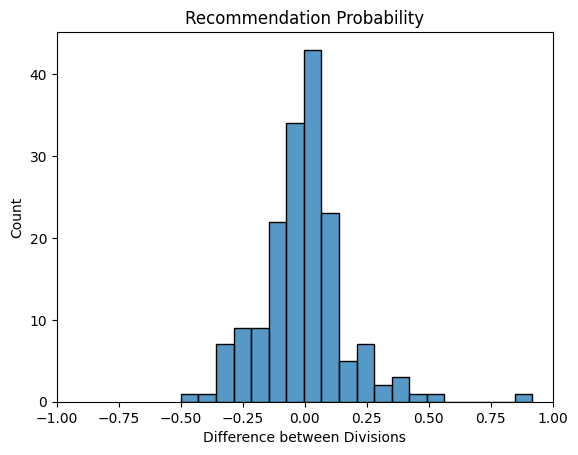

In [66]:
valid_ids = df['Clothing ID'].value_counts()
filtered_df = df[df['Clothing ID'].isin(valid_ids[valid_ids >= 10].index)]

avg_recommendation = filtered_df.groupby(['Clothing ID', 'Division Name'])['Recommended IND'].mean().unstack().dropna()
avg_recommendation['Difference between Divisions'] = avg_recommendation['General'] - avg_recommendation['General Petite']

sns.histplot(avg_recommendation, x="Difference between Divisions", bins=20, kde=False)
plt.xlim([-1, 1])
plt.title("Recommendation Probability")
plt.show()

Observations:
* Some articles seem to get a better/worse rating depending on the division.

# 4 Age statistics

Does the age influence the chance of giving a positive review?

Conclusion:
* Positive or Negative reviews don't seem to be related to Age.

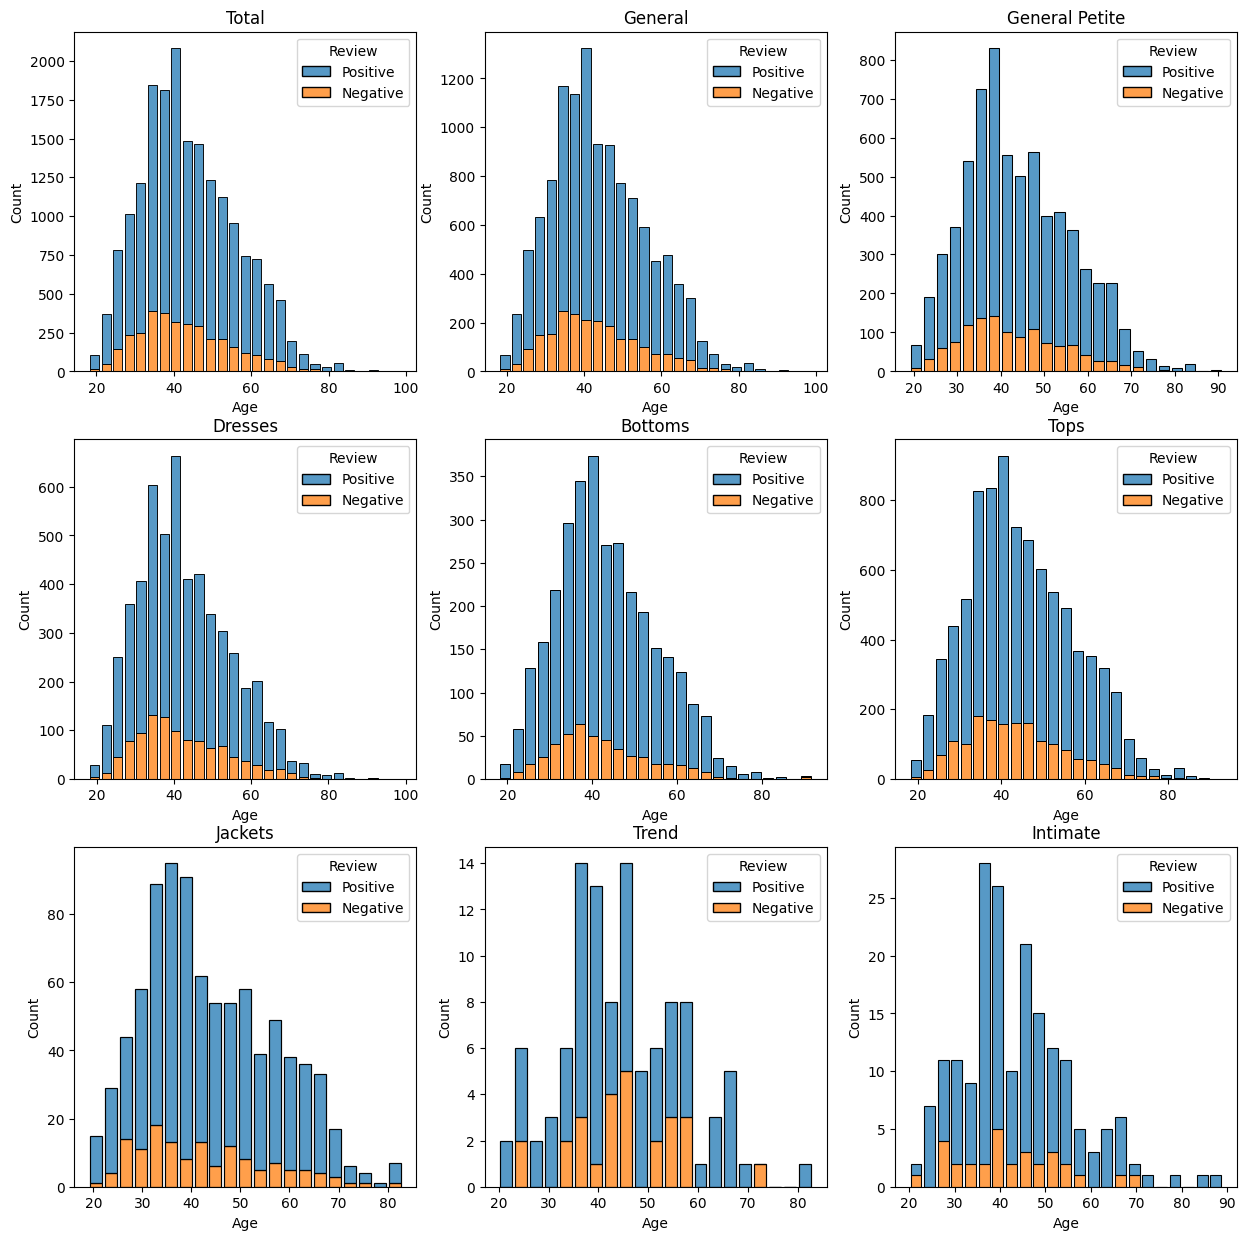

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

sns.histplot(data=df, x="Age", binwidth=3, ax=axes[0], hue='Review', multiple='stack', shrink = 0.78, hue_order=["Positive", "Negative"])
axes[0].set_title('Total')
for i, division in enumerate(df['Division Name'].unique()):
    sns.histplot(data=df[df['Division Name'] == division], x="Age", binwidth=3, ax=axes[i + 1], hue='Review', multiple='stack', shrink = 0.8, hue_order=["Positive", "Negative"])
    axes[i + 1].set_title(division)

for i, department in enumerate(df['Department Name'].unique()):
    sns.histplot(data=df[df['Department Name'] == department], x="Age", binwidth=3, ax=axes[i + 3], hue='Review', multiple='stack', shrink = 0.8, hue_order=["Positive", "Negative"])
    axes[i + 3].set_title(department)


Observations:
* The customers's age has a broad span (18-99), with the main target being people around 43.
* The distribution doesn't evidently change depending on the **Division** or **Department**

# 5 Positive Feedback Statistics

What does Positive Feedback Count mean and does it relate to the positive review probability?

Conclusions:
* I don't understand what Positive Feedback Counts stands for...
* There is a small relation to review outcome, making it worth considering for the model.

In [6]:
print("Percentile")
for q in np.linspace(0, 1, 11):
    print(f"\t{q * 100:.0f}% = {df["Positive Feedback Count"].quantile(q)}")

Percentile
	0% = 0.0
	10% = 0.0
	20% = 0.0
	30% = 0.0
	40% = 0.0
	50% = 1.0
	60% = 1.0
	70% = 2.0
	80% = 4.0
	90% = 7.0
	100% = 122.0


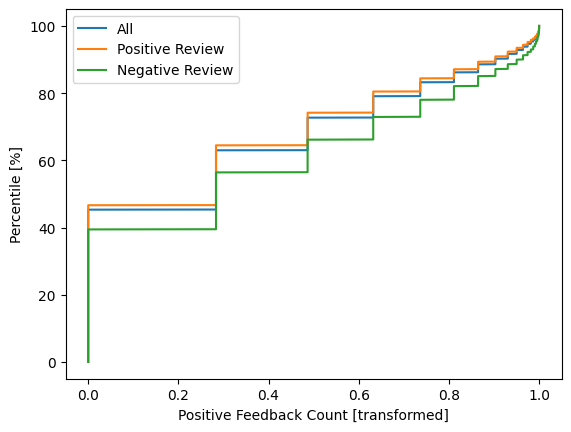

In [8]:
def transform(x, k=3):
    return 1 - np.exp(-x/k)

plt.figure()
plt.plot(sorted(transform(df["Positive Feedback Count"])), np.linspace(0, 100, len(df)), label="All")

df_positive = df[df["Review"] == "Positive"]
plt.plot(sorted(transform(df_positive["Positive Feedback Count"])), np.linspace(0, 100, len(df_positive)), label="Positive Review")

df_positive = df[df["Review"] == "Negative"]
plt.plot(sorted(transform(df_positive["Positive Feedback Count"])), np.linspace(0, 100, len(df_positive)), label="Negative Review")

plt.xlabel("Positive Feedback Count [transformed]")
plt.ylabel("Percentile [%]")
plt.legend()
plt.show()

Does age play a role in the positive feedback count?

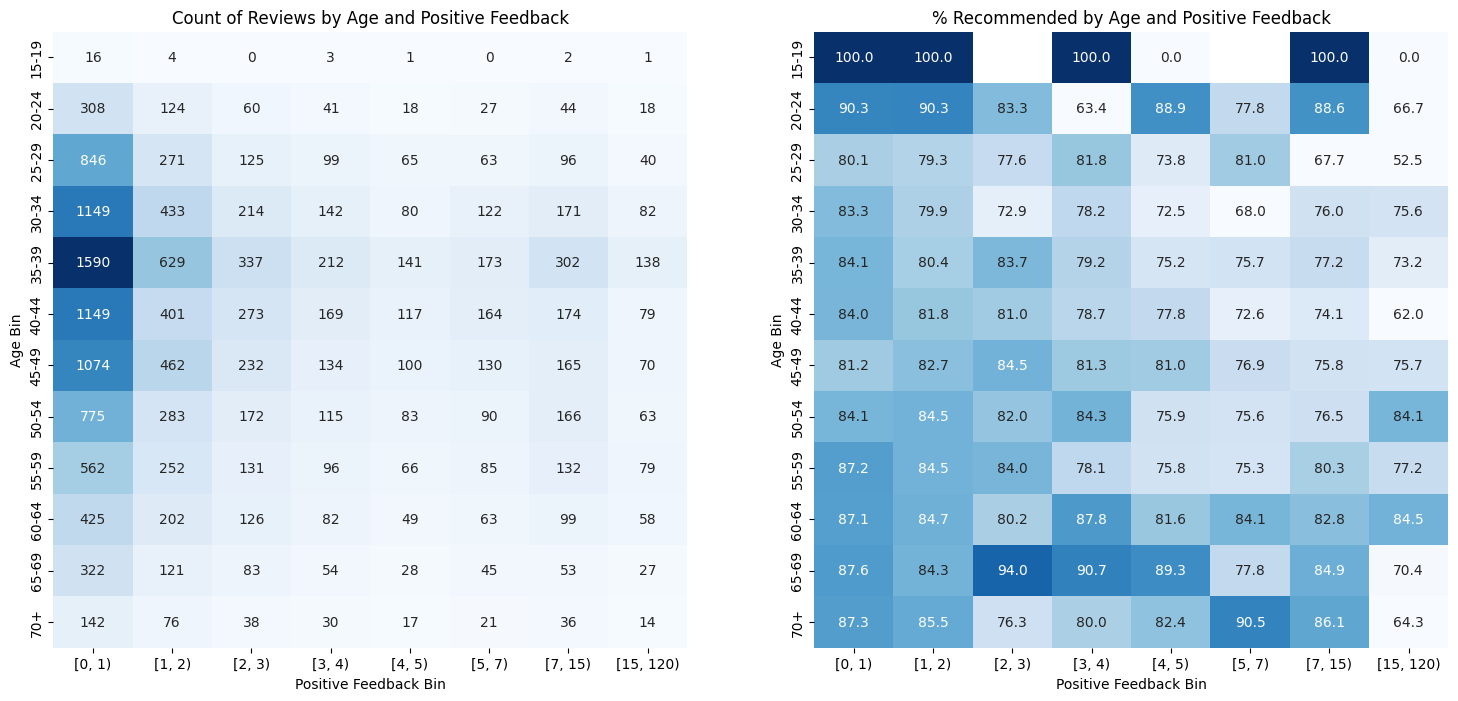

In [67]:
bins = list(range(15, 71, 5)) + [100]
labels = [f"{i}-{i+4}" for i in range(15, 70, 5)] + ["70+"]
df['Age Bin'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

bins = [0, 1, 2, 3, 4, 5, 7, 15, 120]
df['Positive Feedback Bin'] = pd.cut(df['Positive Feedback Count'], bins=bins, right=False)

count_matrix = df.pivot_table(index='Age Bin', columns='Positive Feedback Bin', aggfunc='size', fill_value=0, observed=True)

percentage_matrix = df.pivot_table(index='Age Bin', columns='Positive Feedback Bin', values='Recommended IND',
                                   aggfunc=lambda x: np.mean(x)*100, fill_value=np.nan, observed=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.heatmap(count_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Count of Reviews by Age and Positive Feedback')
sns.heatmap(percentage_matrix, annot=True, fmt='.1f', cmap='Blues', ax=axes[1], cbar=False, vmin=70, vmax=100)
axes[1].set_title('% Recommended by Age and Positive Feedback')

plt.show()

Obervations:
* The values are very skewed to zero, with some large outliers.
* There seems to be no direct relation to Age.
* Small relation to review outcome, making it worth considering for the model.

# 6 Review Statistics

## 6.1 NLP methods

### Create look-up table for sentiment score

Check the most common words in the title and text. With this information we can make a rudimentary sentiment score.

#### Review Title

In [ ]:
adjective_counter = Counter()
pronoun_counter = Counter()
conj_counter = Counter()

for text in df['Title']:
    doc = nlp(text)
    adjective_counter.update(
        token.lemma_.lower() for token in doc if token.pos_ == 'ADJ'
    )
    pronoun_counter.update(
        token.lemma_.lower() for token in doc if token.pos_ == 'PROPN'
    )
    conj_counter.update(
        token.lemma_.lower() for token in doc if token.pos_ == 'CCONJ'
    )


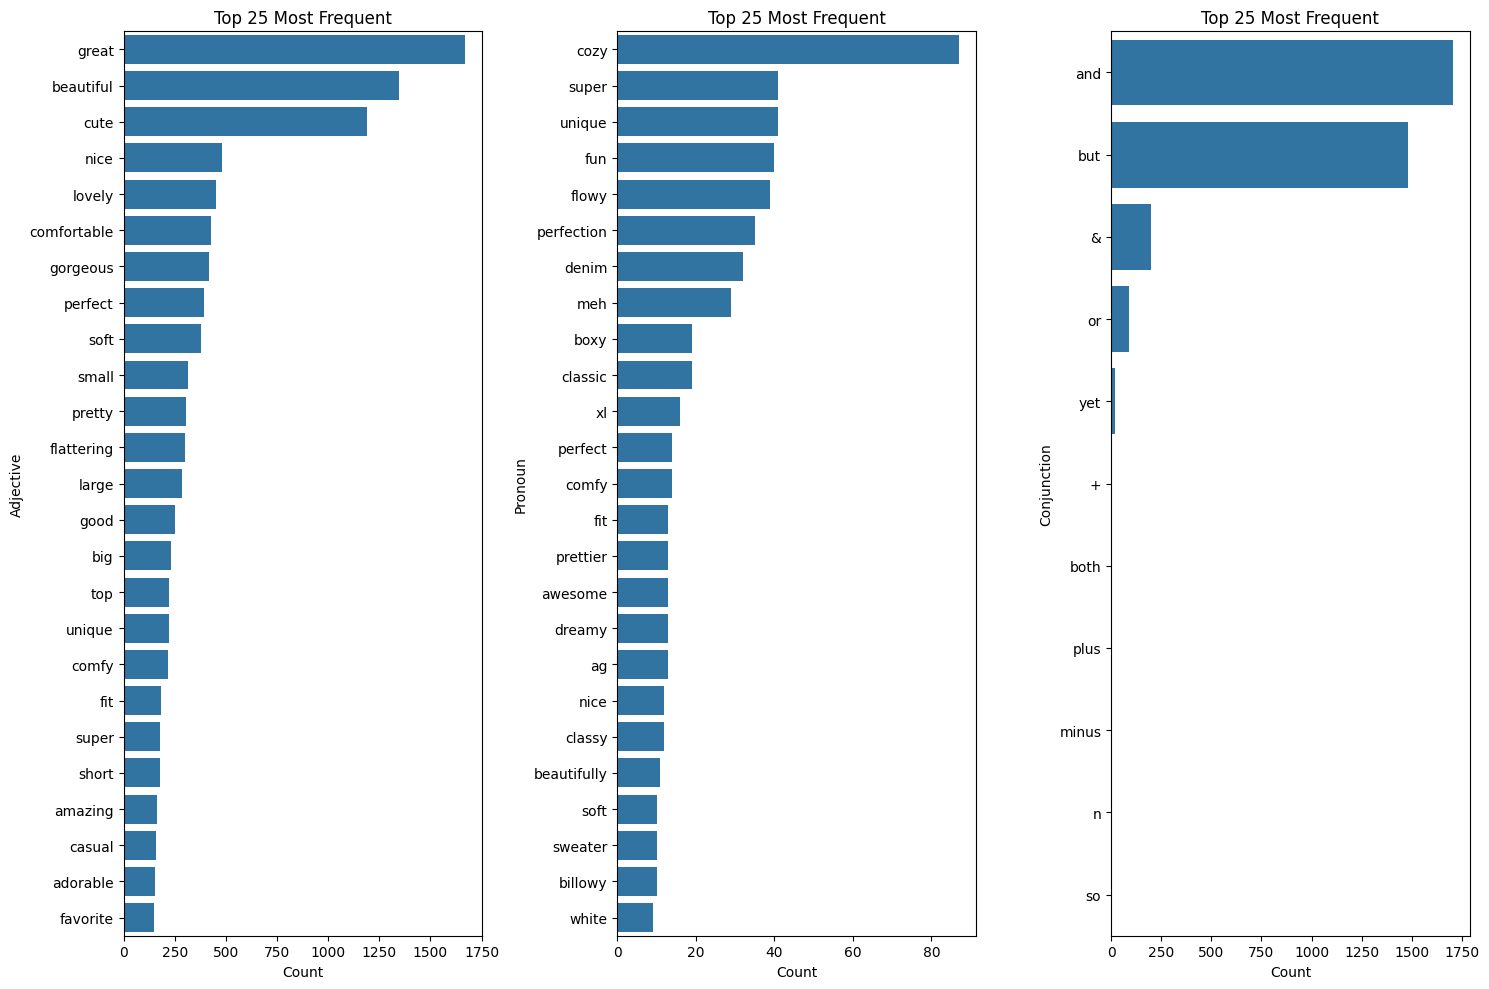

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
for name, counter, axis in zip(["Adjective", "Pronoun", "Conjunction"],
                               [adjective_counter, pronoun_counter, conj_counter],
                               axes.flatten()):

    most_common = counter.most_common(30)
    adj_df = pd.DataFrame(most_common, columns=[name, 'Frequency'])

    sns.barplot(data=adj_df, x='Frequency', y=name, ax=axis)
    axis.set_title('Top 25 Most Frequent')
    axis.set_xlabel('Count')
    axis.set_ylabel(name)

plt.tight_layout()
plt.show()

#### Review Text

In [ ]:
adjective_counter = Counter()
pronoun_counter = Counter()
conj_counter = Counter()

for text in df['Review Text']:
    doc = nlp(text)
    adjective_counter.update(
        token.lemma_.lower() for token in doc if token.pos_ == 'ADJ'
    )
    pronoun_counter.update(
        token.lemma_.lower() for token in doc if token.pos_ == 'PROPN'
    )
    conj_counter.update(
        token.lemma_.lower() for token in doc if token.pos_ == 'CCONJ'
    )


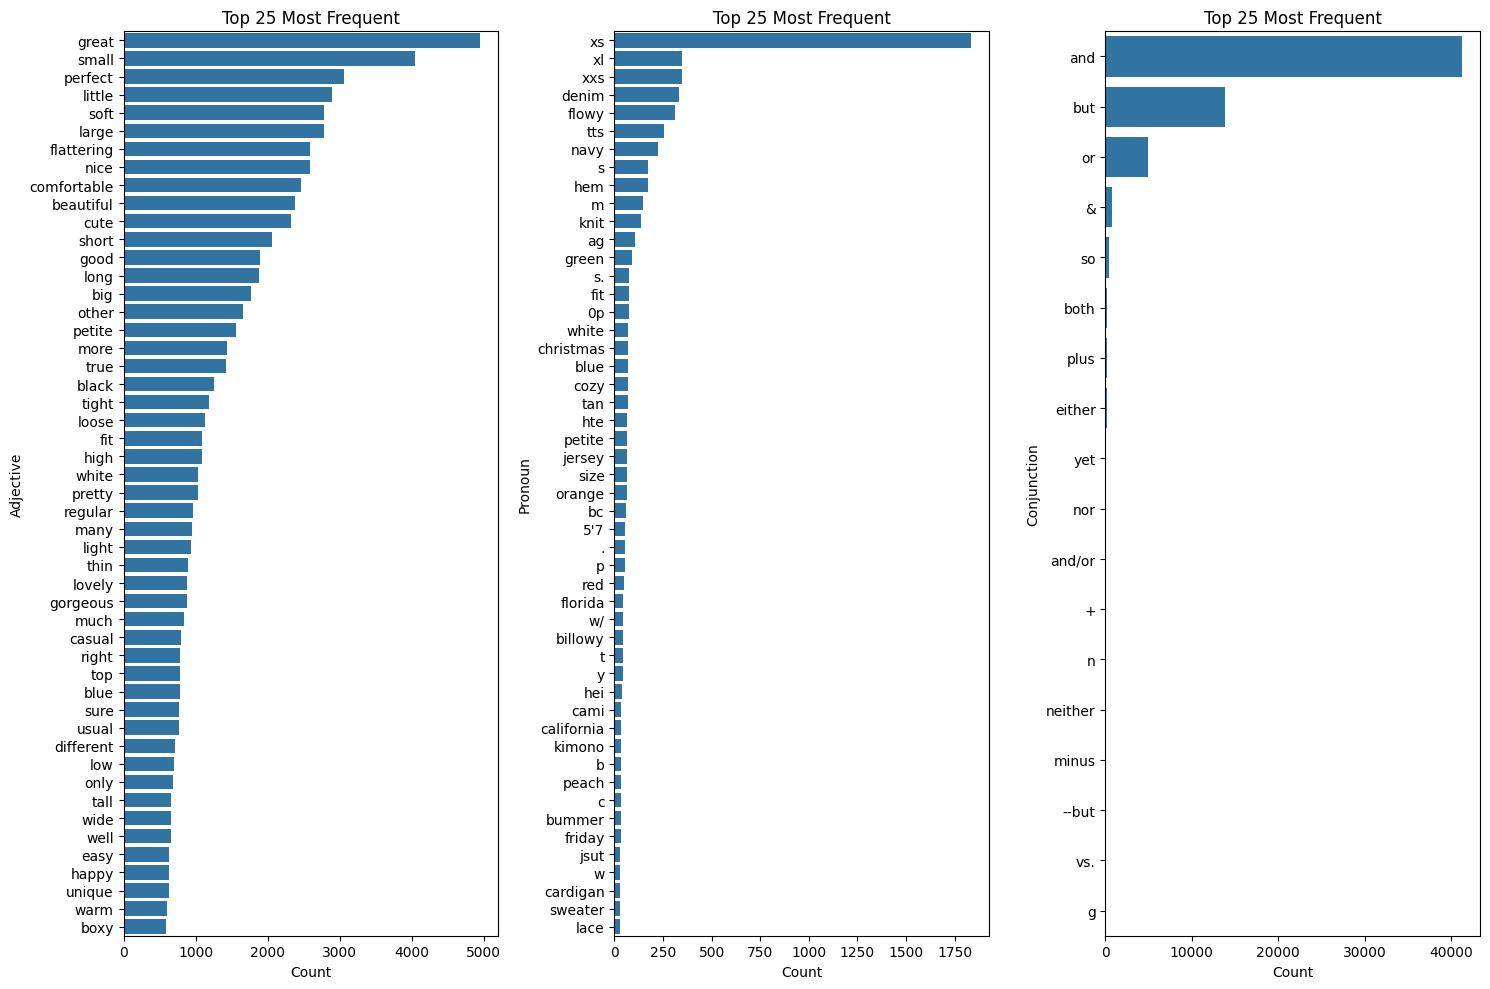

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
for name, counter, axis in zip(["Adjective", "Pronoun", "Conjunction"],
                               [adjective_counter, pronoun_counter, conj_counter],
                               axes.flatten()):

    most_common = counter.most_common(30)
    adj_df = pd.DataFrame(most_common, columns=[name, 'Frequency'])

    sns.barplot(data=adj_df, x='Frequency', y=name, ax=axis)
    axis.set_title('Top 25 Most Frequent')
    axis.set_xlabel('Count')
    axis.set_ylabel(name)

plt.tight_layout()
plt.show()

### Method Definitions

In [ ]:
def count_characters(text):
    return {
        'Word Count': len(text.split(' ')),
        'Unique Word Count': len(set(text.split())),
        'Point Count': text.count('.'),
        'Comma Count': text.count(','),
        'Semicolon Count': text.count(';'),
        'Quotes Count': text.count('"') + text.count("'"),
        'Exclamation Count': text.count('!'),
        'Question Count': text.count('?'),
        'Hashtag Count': text.count('#'),
        'Ellipsis Count': text.count('...') + text.count('..'),
        'ALL CAPS Words': sum(1 for word in text.split() if word.isupper() and len(word) > 1),
    }


def process_nlp(text):
    doc = nlp(text)
    return {
        'num_tokens': len(doc),
        'num_sentences': len(list(doc.sents)),
        'num_pronoums': sum(1 for token in doc if token.pos_ == 'PROPN'),
        'num_adjectives': sum(1 for token in doc if token.pos_ == 'ADJ'),
        'num_verbs': sum(1 for token in doc if token.pos_ == 'VERB'),
        'num_nouns': sum(1 for token in doc if token.pos_ == 'NOUN'),
        'num_conjunctions': sum(1 for token in doc if token.pos_ == 'CCONJ'),
        'num_numbers': sum(1 for token in doc if token.pos_ == 'NUM'),
        'num_symbols': sum(1 for token in doc if token.pos_ == 'SYM'),
        'num_entities': len(doc.ents)
    }


# Sentiment Score
positive_sentiment = ["great", "beautiful", "cute", "nice", "lovely", "comfortable", "gorgeous", "perfect",
                  "pretty", "flattering", "good", "comfy", "amazing", "adorable", "stylish", "cozy", "fun",
                  "perfection", "perfect", "awesome"]
negative_sentiment = ["poor", "meh", "boxy", "scratchy", "shapeless", "odd", "thin", "weird", "disapointing",
                      "awkward", "bummer", "unflattering", "bad", "strange", "itchy", "cheaply", "cheap",
                      "stiff", "minus"]
mixed_sentiment = ["but", "yet", "or"]


def sentiment_score(text):
    doc = nlp(text)
    positive_count = 0
    negative_count = 0
    mixed_count = 0
    for token in doc:
        if token.pos_ in ['ADJ', 'PROPN', 'CCONJ']:
            if token.lemma_.lower() in positive_sentiment:
                positive_count += 1
            elif token.lemma_.lower() in negative_sentiment:
                negative_count += 1
            elif token.lemma_.lower() in mixed_sentiment:
                mixed_count += 1
    return {
        'positive_count': positive_count,
        'negative_count': negative_count,
        'mixed_count': mixed_count,
        }


def apply(df, column, func):
    return pd.concat(
        [df[['Recommended IND']], df[column].apply(func).apply(pd.Series)],
        axis=1).groupby('Recommended IND').mean().round(2)
    

## 6.2 Special Characters

In [81]:
print("Title:")
display(apply(df, "Title", count_characters).T)


print("Review Text:")
display(apply(df, "Review Text", count_characters).T)

Title:


Recommended IND,0,1
Word Count,3.66,3.27
Unique Word Count,3.64,3.25
Point Count,0.26,0.10
Comma Count,0.13,0.11
Semicolon Count,0.00,0.00
Quotes Count,0.05,0.03
Exclamation Count,0.11,0.29
Question Count,0.01,0.01
Hashtag Count,0.00,0.00
Ellipsis Count,0.15,0.05


Review Text:


Recommended IND,0,1
Word Count,63.82,62.16
Unique Word Count,49.12,48.21
Point Count,4.73,4.50
Comma Count,2.44,2.19
Semicolon Count,0.05,0.05
Quotes Count,1.64,1.66
Exclamation Count,0.31,0.69
Question Count,0.05,0.03
Hashtag Count,0.02,0.02
Ellipsis Count,0.31,0.27


Title Observations:
* Longer titles might indicate a negative review.
* Shorter sentences (or with more commas) might indicate a negative review.
* Number of ellipsis might indicate a negative review.
* More exclamations might indicate a positive review.

Text Observations:
* Number of exlamation marks indicate positive review.
* Number of ellipsis indicate negative review.

## 6.3 Part-of-Speech

In [82]:
print("Title:")
display(apply(df, "Title", process_nlp).T)


print("Review Text:")
display(apply(df, "Review Text", process_nlp).T)

Title:


Recommended IND,0,1
num_tokens,4.14,3.80
num_sentences,1.01,1.01
num_pronoums,0.08,0.07
num_adjectives,0.84,0.94
num_verbs,0.44,0.33
num_nouns,0.76,0.92
num_conjunctions,0.20,0.19
num_numbers,0.01,0.01
num_symbols,0.01,0.01
num_entities,0.07,0.11


Review Text:


Recommended IND,0,1
num_tokens,73.97,72.42
num_sentences,4.99,5.17
num_pronoums,0.46,0.58
num_adjectives,6.37,6.99
num_verbs,7.89,7.50
num_nouns,10.81,11.05
num_conjunctions,3.23,3.40
num_numbers,0.90,1.04
num_symbols,0.13,0.15
num_entities,1.06,1.29


Title Observations:
* Longer titles are associated to lower recommendations.
* More Nouns and Adjectives correlate to higher recommendations.

Text Observations:
* More sentences are associated to higher recommendations.

## 6.4 Sentiment Score

In [83]:
print("Title:")
display(apply(df, "Title", sentiment_score).T)


print("Review Text:")
display(apply(df, "Review Text", sentiment_score).T)

Title:


Recommended IND,0,1
positive_count,0.21,0.50
negative_count,0.18,0.01
mixed_count,0.15,0.07


Review Text:


Recommended IND,0,1
positive_count,0.96,1.60
negative_count,0.53,0.14
mixed_count,1.07,1.02


Title Observations:
* Words related to positive sentiment are a good indication of a positive review.
* Negative and mixed sentiment are good indication of a negative review.

Text Observations:
* Strangely, positive sentiments are linked to negative recommenations. Maybe the review describes what was expected?
* Negatve sentiments are linked to negative recommendations, as expected.